# Length of stay in hospital and in ICU for adult patients
This notebook consists of two queries that are related in topic. Namely, we are interested in the length of stay in hospital across different care units, and the length of stay in ICU across care units.

## 1. Length of stay on the ICU across care units
We would like to know how many days each patient has to stay on the ICU. We want to know the median, lower quantile and upper quantile for the length of stay, and also these values for each different ICU. As for all queries, we only select adult patients (age >= 16). 

### SQL query description
The length of stay on the ICU can be found in the Icustays table. We also need the corresponding care unit and time of admission of each ICU admission. To get the date of birth for each patient (and hence the age, computed from the admission time and date of birth), we combine the Icustays and Patients tables.

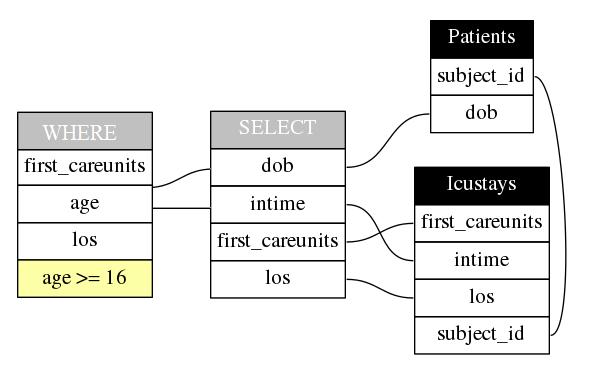

In [1]:
from IPython.display import Image
Image("../patient_population_queries/SQL_query_diagrams/length_of_stay_ICU.png", width=500)

### Implementation of the above query

In [4]:
# Imports:
import numpy as np
import pandas as pd
import sys
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys

# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'

# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

Median of length of stay on ICU (in days):  2.14425
Lower quartile of length of stay on ICU (in days):  1.2056
Upper quartile of length of stay on ICU (in days):  4.192550000000001

Median length of stay on ICU (in days) per intensive care unit: 
                    los
first_careunit         
CCU             2.19775
CSRU            2.15295
MICU            2.09560
SICU            2.25220
TSICU           2.11260

Lower quartile of length of stay on ICU (in days) per intensive care unit: 
                     los
first_careunit          
CCU             1.213225
CSRU            1.215925
MICU            1.189200
SICU            1.251550
TSICU           1.166850

Upper quartile of length of stay on ICU (in days) per intensive care unit: 
                     los
first_careunit          
CCU             4.148550
CSRU            3.962475
MICU            4.095800
SICU            4.932700
TSICU           4.678825


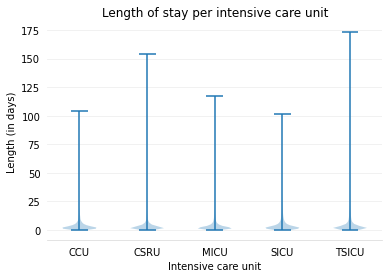

In [5]:
query = \
"""
SELECT p.subject_id, i.first_careunit, i.los,
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i ON p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""

query_output = pd.read_sql_query(query,con)
print('Median of length of stay on ICU (in days): ', query_output.los.median())
print('Lower quartile of length of stay on ICU (in days): ', query_output.los.quantile(0.25))
print('Upper quartile of length of stay on ICU (in days): ', query_output.los.quantile(0.75))

print('\nMedian length of stay on ICU (in days) per intensive care unit: ')
print(query_output[['first_careunit', 'los']].groupby('first_careunit').median())
print('\nLower quartile of length of stay on ICU (in days) per intensive care unit: ')
print(query_output[['first_careunit', 'los']].groupby('first_careunit').quantile(0.25))
print('\nUpper quartile of length of stay on ICU (in days) per intensive care unit: ')
print(query_output[['first_careunit', 'los']].groupby('first_careunit').quantile(0.75))

# Visualize with a violin plot:
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
boxplot_data = {}
for c in care_units:
    los = query_output.loc[query_output['first_careunit'] == c].los
    boxplot_data[c] = [x for x in los if str(x) != 'nan']
    
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
fig, ax = plt.subplots()
plt.title('Length of stay per intensive care unit', fontsize='large', fontweight='roman')
plt.xlabel('Intensive care unit')
plt.ylabel('Length (in days)')
ax.violinplot(boxplot_data.values())
ax.set_xticks(np.arange(1, len(care_units) + 1))
ax.set_xticklabels(boxplot_data.keys())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.savefig('figures/length_of_stay_ICU_violin.jpg', dpi=400)  

## 2. Length of stay in hospital across care units
This query is almost similar to the previous one, but now we are interested in the length of stay (in days) of adult patients in hospital instead of on the ICUs. We are also interested to know the distribution of those values across ICUs

### SQL query description
We combine the Patients and Icustays tables based on the subject identifier, and the Admissions table based on the unique hospital admission identifier. This time, we use date of birth and time of admission to the hospital to compute age, and filter on it using age >= 16. There is no variable for length of stay in hospital, but we can compute it by subtracting the discharge time from the admission time. Moreover, we will need the ICU the patient is admitted to. The unique hospital admission identifier is used to make sure each hospital admission corresponds to only one ICU (we use the hospital admission identifier to remove duplicates).

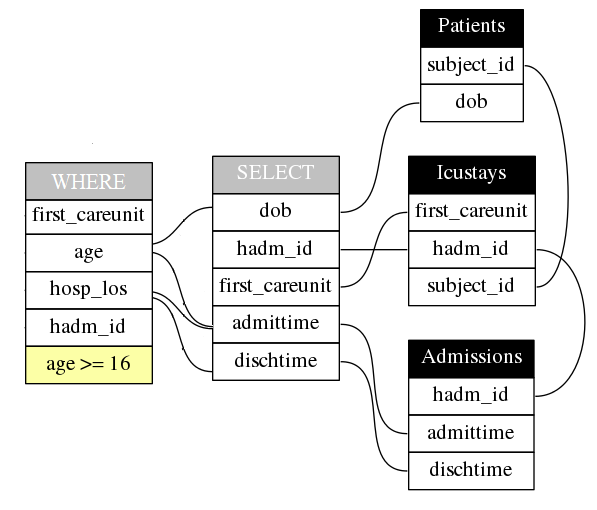

In [6]:
from IPython.display import Image
Image("../patient_population_queries/SQL_query_diagrams/length_of_stay_hospital.png", width=500)

### Implementation of the above query

Median of length of stay in hospital (in days):  6.9111
Lower quantile of length of stay in hospital (in days):  4.0264
Upper quantile of length of stay in hospital (in days):  11.9354

Median length of stay in hospital (in days) per intensive care unit: 
                hospital_los
first_careunit              
CCU                   5.7569
CSRU                  7.3583
MICU                  6.4222
SICU                  7.9313
TSICU                 7.4958

Lower quantile of length of stay in hospital (in days) per intensive care unit: 
                hospital_los
first_careunit              
CCU                  3.10490
CSRU                 5.25000
MICU                 3.67360
SICU                 4.41530
TSICU                4.07885

Upper quantile of length of stay in hospital (in days) per intensive care unit: 
                hospital_los
first_careunit              
CCU                 10.02570
CSRU                11.18750
MICU                11.72920
SICU                14.24065


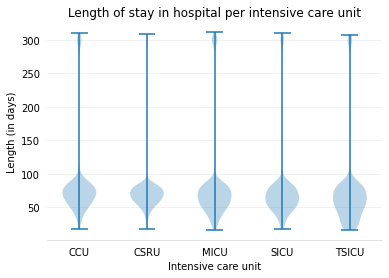

In [7]:
query = \
"""
SELECT p.subject_id, i.first_careunit, i.hadm_id,
round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age,
round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hospital_los
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i ON p.subject_id = i.subject_id
INNER JOIN mimiciii.admissions a ON a.hadm_id = i.hadm_id
WHERE round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16;
"""

query_output = pd.read_sql_query(query,con)
print('Median of length of stay in hospital (in days): ', query_output.drop_duplicates(['hadm_id']).hospital_los.median())
print('Lower quantile of length of stay in hospital (in days): ', 
      query_output.drop_duplicates(['hadm_id']).hospital_los.quantile(0.25))
print('Upper quantile of length of stay in hospital (in days): ', 
      query_output.drop_duplicates(['hadm_id']).hospital_los.quantile(0.75))

print('\nMedian length of stay in hospital (in days) per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id'])[['first_careunit','hospital_los']].groupby('first_careunit').median())
print('\nLower quantile of length of stay in hospital (in days) per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id'])[['first_careunit','hospital_los']]
      .groupby('first_careunit').quantile(0.25))
print('\nUpper quantile of length of stay in hospital (in days) per intensive care unit: ')
print(query_output.drop_duplicates(['hadm_id'])[['first_careunit','hospital_los']]
      .groupby('first_careunit').quantile(0.75))

# Visualize with a violin plot:
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
boxplot_data = {}
for c in care_units:
    boxplot_data[c] = query_output.loc[query_output['first_careunit'] == c].age
    
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
fig, ax = plt.subplots()
plt.title('Length of stay in hospital per intensive care unit', fontsize='large', fontweight='roman')
plt.xlabel('Intensive care unit')
plt.ylabel('Length (in days)')
ax.violinplot(boxplot_data.values())
ax.set_xticks(np.arange(1, len(care_units) + 1))
ax.set_xticklabels(boxplot_data.keys())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
fig.savefig('figures/length_of_stay_hospital_violin.jpg', dpi=400)